---
title: Dimensionality projections and topology diagnostics
summary: An example of how to use dimensionality projections with the package `topometry`, with some usage of diagnostic tools for comparison of distortions and visualization of eigenvectors.
author: Samuele Soraggi
date-modified: last-modified
date-format: long
date: 2024-09-11
code-fold: false
bibliography: ../resources/references.bib
---

# Workshop start

Here you will go through some different ways of projecting single cell data. You start with PCA-based projections, then move to geometry-based projections and diagnostic ways of choosing the method which matches best your data.
At the end, you will

- understand briefly the difference between **modeling distances and geometry**
- know how to apply the methods **with scanpy**
- be able to **compare the methods** and their **distortions**

# Notebook setup

Here we install some packages, download a file with scripts and the data from the github repository

In [2]:
%pip install --quiet scanpy topometry hnswlib pacmap plotly igraph leidenalg scvelo jupyterquiz git+https://github.com/DmitryUlyanov/Multicore-TSNE.git

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 830.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.1/210.1 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s

Load packages

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from scipy.cluster import hierarchy as sch
import re
import pacmap
import topo as tp
import scvelo as scv
from jupyterquiz import display_quiz
from matplotlib import pyplot as plt
import scanpy as sc
import plotly.express as px

%matplotlib inline

Setup some default figure parameters

In [4]:
scv.set_figure_params('scvelo', dpi=100, fontsize=14, dpi_save=600, format='tif')

Download scripts

In [5]:
!wget -q https://github.com/hds-sandbox/scverse-2024-workshop/raw/main/Scripts/scripts.py
%run scripts.py

Download data from github repository

In [6]:
!wget -q https://github.com/hds-sandbox/scverse-2024-workshop/raw/main/Data/testis.h5ad.gz
!gunzip testis.h5ad.gz

## Data

The dataset is from human testicular tissue, that is divided in round tubules. Each tubule contains spermatogonia cells which are the beginning of the differentiation process, which leads to elongating spermatids (spermatozoa). See figure below.

Other somatic cell types assist the differentiation and movement of cells, and are usually out of the tubules. **Below:** a section of testis tissue where cells differentiate inside a tubule to become spermatozoa towards the center.

![](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/nb/images/celltypes.png)

The dataset is a subsample of 10,000 cells from ([Winge et al., 2020](https://pubmed.ncbi.nlm.nih.gov/32449318/)), already filtered down to 7765 cells. The full data [is downloadable](https://cells.ucsc.edu/?ds=testis) and you can find the exact filtering procedure in our [summer school tutorial](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/nb/04_scRNAseq_analysis.html).

We read the data in h5ad format

In [7]:
adata = sc.read("testis.h5ad")

This is an annotated data (anndata) object. You can look at the object size and content here. We mostly have some cell-related QC measures in `obs`, and the number of cells expressing each gene in `var`.

In [8]:
adata

AnnData object with n_obs × n_vars = 7765 × 27897
    obs: 'batch', 'super_batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'perc_mito', 'perc_MALAT1', 'n_genes'
    var: 'n_cells'

Here we proceed with just a rough normalization in the interest of time (transcript per million + logarithm + standardization). In the meanwhile we determine the 5000 most variable genes. A bit more info on normalization [here](https://hds-sandbox.github.io/NGS_summer_course_Aarhus/nb/04_scRNAseq_analysis.html#data-normalization) if you want to read. Also consider [this paper](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2020.00041/full) and the [scVerse best practices chapter on normalization](https://www.sc-best-practices.org/preprocessing_visualization/normalization.html).

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
sc.pp.scale(adata, max_value=10)

# Projections

Now we look at various projections methods.

## PCA

We start with the usual projection methods everyone starts with after preprocessing, PCA.

**PCA is usually the starting point of most calculations in scRNA analysis.**

The PCA plot is not able to show much structure in the data, it seems we simply have two long clusters of cells.

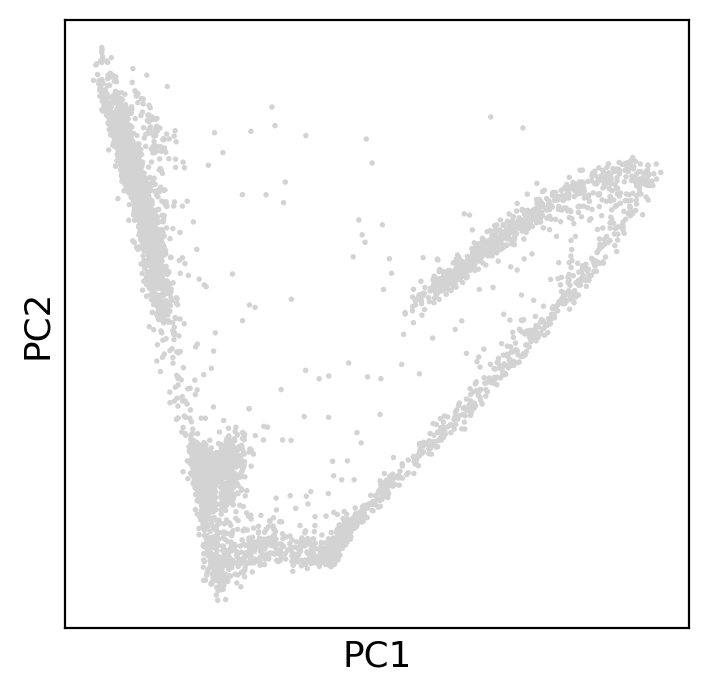

In [10]:
sc.pp.pca(adata, random_state=123) #calculate PCA
plt.rcParams['figure.figsize']=(4,4)
sc.pl.pca(adata) #plot PCA

How many components are we able to detect with PCA's linear separation? It seems 10 principal components contain most of the data's variance.

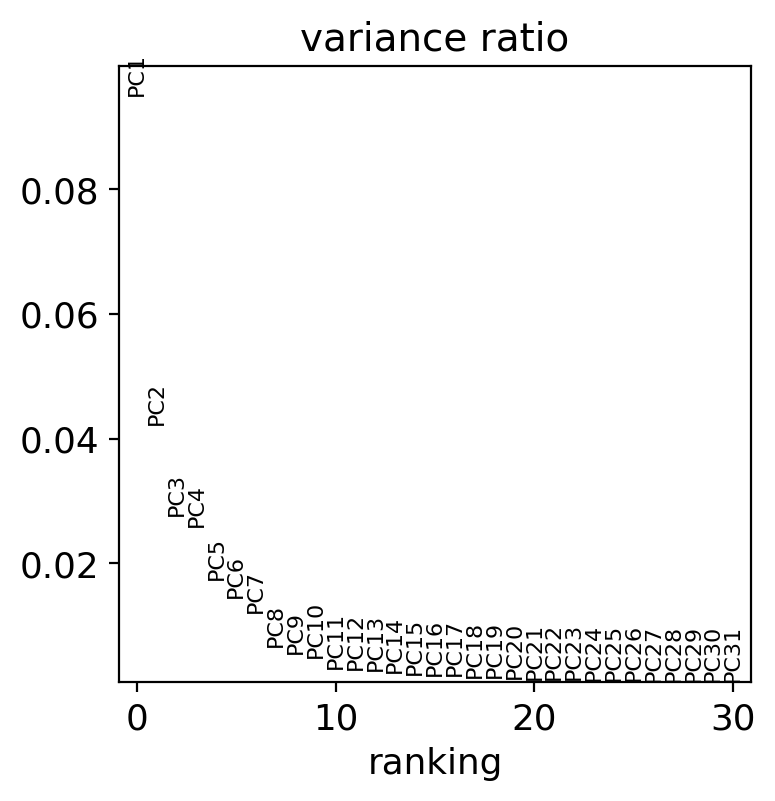

In [11]:
sc.pl.pca_variance_ratio(adata)

In [12]:
#| echo: false
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz00.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

## tSNE

Now we want to try out tSNE. tSNE is a graph optimization algorithm, and it is based on optimizing a cost function which balances two *strenghts*: an **attractive** one and a **repulsive** one.

The **attractive force** draws points closer to each other privileging the global structure (e.g. overall relative position of clusters), while the **repulsive force** pushes distant points far away, preserving the local structure (e.g. such as cluster separation). More on tSNE [in the original paper](https://jmlr.org/papers/v9/vandermaaten08a.html) and in this [guidance paper](https://arxiv.org/abs/2105.07536).

Distances are calculated through a **gaussian kernel in high-dimensional data, and with t-student in the projection** (figure below). A parameter called *perplexity* determines the width of the gaussian.

![](https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/webpage-quarto/img/kernels.png)

We try to plot tSNE with perplexities 1, 10, 100 to see how we can get different tSNEs.

First of all, we calculate distances on the 10 PCA components - **which means tSNE will be based on PCA distances** (so a non-linear projection is using a linear projection to start with).

In [13]:
sc.pp.neighbors(adata, n_pcs=10, random_state=123)

Now we run tSNE three times and plot it. We use only 1000 cells because it runs otherwise slow.

In [14]:
perps = [1,10,100]
adata_subset = sc.pp.subsample(adata, n_obs=1000, copy=True)
for i in range(3):
  sc.tl.tsne(adata_subset, perplexity=perps[i], n_jobs=4, n_pcs=10, random_state=123)
  adata_subset.obsm[f'X_tsne_P{perps[i]}_'] = adata_subset.obsm[f'X_tsne'].copy()

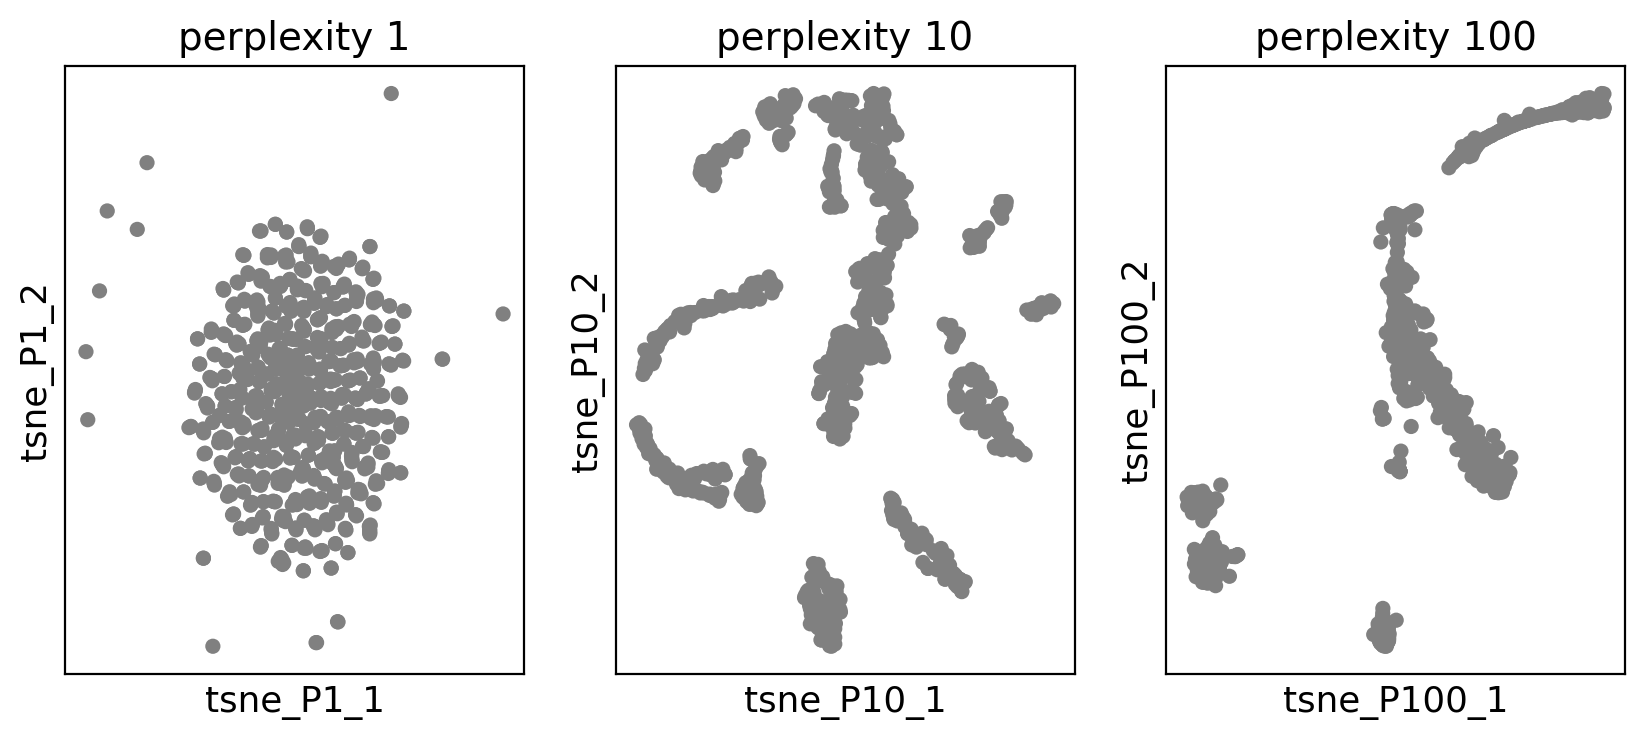

In [15]:
plt.rcParams['figure.figsize']=(10,4)
fig, axs = plt.subplots(1,3)
perps = [1,10,100]
for i in range(3):
  f=sc.pl.scatter(adata_subset, basis=f'tsne_P{perps[i]}_', ax=axs[i],
                show=False, title=f'perplexity {perps[i]}')
fig.show()

In [16]:
#| echo: false
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz01.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

## UMAP

UMAP is also a graph optimization algorithm like tSNE. It also ends up **balancing attractive and repulsive forces** like the tSNE algorithm. Those two forces change their weight using parameters *a* and *b*.

**Choose below the a and b parameters** and test which plot you get. Try as many times as you want before continuing. Usually, values of `a` and `b` are not much distant from 1 and chosen automatically by UMAP, but it is worth tuning them to see the effect. Here the range is restricted to [0.1-2]


Chosen parameters 0.95 and 1.05
running UMAP...
Plotting


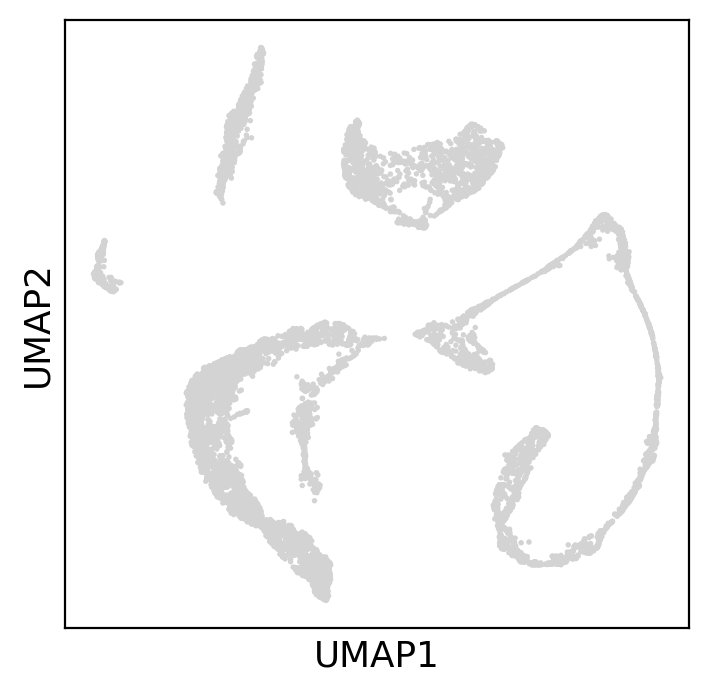

In [17]:
# @title #### DIY: UMAP parameters choice {display-mode: "form"}

a = 1 # @param {type:"slider", min:0.1, max:2, step:0.05}
b = 1 # @param {type:"slider", min:0.1, max:2, step:0.05}

print(f'Chosen parameters {a} and {b}')
print('running UMAP...')
sc.tl.umap(adata, a=a, b=b, random_state=123)
print('Plotting')
plt.rcParams['figure.figsize']=(4,4)
fig, axs = plt.subplots(1)
sc.pl.umap(adata, ax=axs, show=True)

In [18]:
#| echo: false
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz02.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

## Geometrical approach - topoMETRY

topoMetry works by **modelling the geometry of the shape formed by the data points in high dimension**. This is done through the so-called discrete Laplace-Beltrami Operator (LBO). For reference, there is a [paper](https://www.biorxiv.org/content/10.1101/2022.03.14.484134v3) and a [documentation page](https://topometry.readthedocs.io/en/latest/) for the package.

### How it works (very, very briefly)

In few words, the LBO finds a sort of principal components (called eigenfunctions or eigenvectors) of the geometrical shape formed by the data, which *pieced together* **approximate the original dataset** (figure below, right).

Usually the **eigenvectors are less than the dimension of the data**, because many of the genes are related by similar expression patterns (figure below, left). The number of eigenvector is the **intrinsic dimensionality** of the data, which tells you **how many dimensions you need to describe the geometry of the data surface.**

![](https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/webpage-quarto/img/LBO.png)

### What can you use the LBO for

The LBO is used in the same way as the PCA, which is, **its eigenvector matrix is the starting point for other dimensionality reductions.** Now, anything you used will be based on geometry and not on PCA distances.

Below we go through the steps of using such a tool. Remember: no distance preservation is involved in calculating the LBO, it is all about the geometry (curvature and tangent space in each point).

### Calculate Intrinsic dimensionality

First of all, we subset the data to the highly variable genes.

In [19]:
adataHVG = adata[:, adata.var.highly_variable].copy()

Then, we calculate the intrinsic dimensionality of the data. This is done with two indices (FSA, MLE) **tested on different neighborhoods of each cell**. Those two indices estimate the same thing, which is, the intrinsic dimensionality of each cell and its neighbors.

The result is a histogram for which the guideline is to choose the peak. However, tails are also important and can give extra dynamics in the data, so I usually select the number of dimensions on the right side of the peak (before the tail flattens out).

FSA and MLE usually are quite concordant. I usually select the highest estimation of intrinsic dimensionality. Here, for example I choose 250 dimensions.

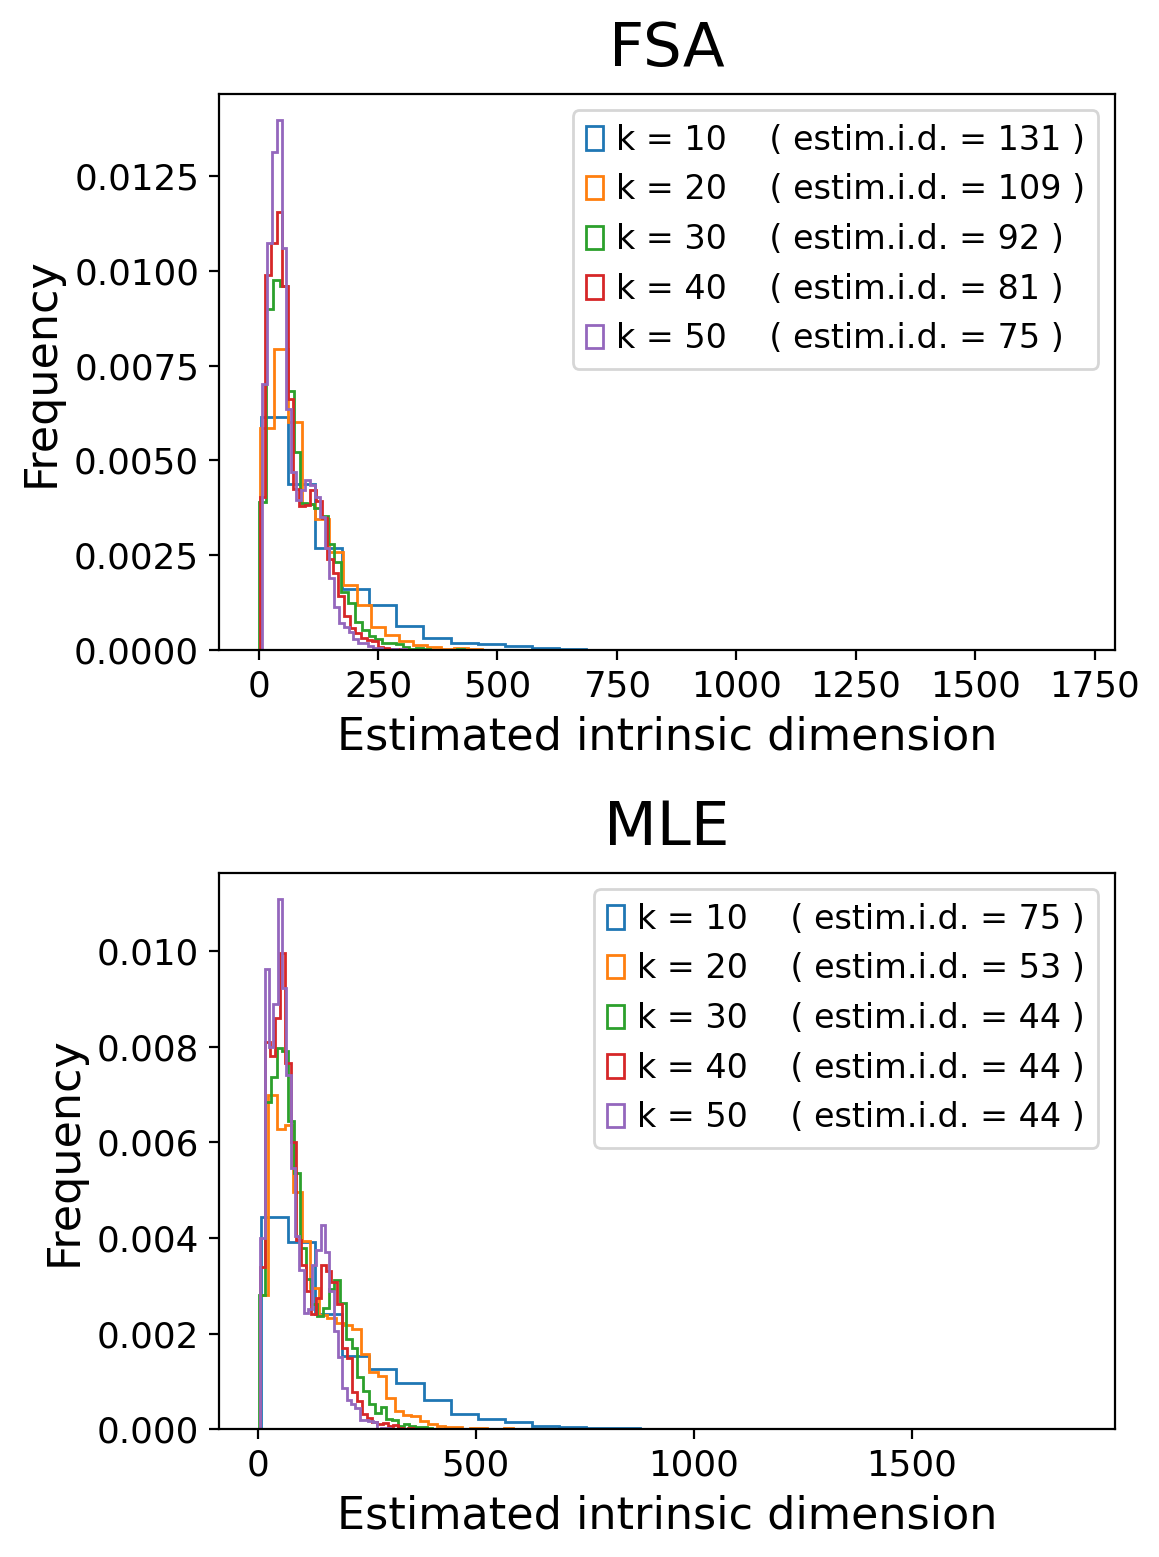

In [20]:
plt.rcParams['figure.figsize']=(4,4)
tp.tpgraph.IntrinsicDim(
        methods=['fsa','mle'],
        k=range(10, 60, 10),
        backend='hnswlib',
        metric='euclidean',
        n_jobs=-1,
        plot=True,
        random_state=123).fit(adataHVG.X)

### Calculate the LBO

Now it is time to calculate the Laplace-Beltrami Operator. This is done in a computer by creating **a matrix, where each column is an eigenvector of the operator**. Every eigenvector describes a geometrical characteristics of the data surface.
Topometry gives choice of methods to calculate LBO with projections and clusters based on that. You can choose

- `kernels` how to calculate similarities
- `eigenmap_method` how to calculate LBO
- `projections` which dimensionality reduction to do starting from LBO
- `resolution` the LBO-based clustering resolution

Do not worry about the first two (find more in the [topometry docs](https://topometry.readthedocs.io/en/latest/)). For the third one we choose [diffusion maps](https://academic.oup.com/bioinformatics/article/31/18/2989/241305) (`MAP`) and `PaCMAP` ([which is superior to UMAP in various ways](https://jmlr.org/papers/v22/20-1061.html)). For the clustering resolution we choose 0.5.

In [21]:
# Run TopOMetry

# Create a TopOGraph object with the desired parameters
tg = tp.TopOGraph(n_eigs=250, n_jobs=-1, verbosity=1, random_state=42)

# Fit some models to the data
adata = tp.sc.topological_workflow(adata, tg,
                                  kernels=['bw_adaptive'],
                                  eigenmap_methods=['LE'],
                                  projections=['MAP', 'PaCMAP'],
                                  resolution=.5)

Computing neighborhood graph...
 Base kNN graph computed in 71.216596 (sec)
 Fitted the bw_adaptive kernel in 1.447921 (sec)
Computing eigenbasis...
 Fitted eigenbasis with Laplacian Eigenmaps from the bw_adaptive in 39.390641 (sec)
    Building topological graph from eigenbasis...
        Computing neighborhood graph...
 Computed in 1.092042 (sec)
 Fitted the bw_adaptive graph kernel in 1.403177 (sec)
 Computed MAP in 12.083399 (sec)
 Computed PaCMAP in 27.849725 (sec)


The resulting projections are inside `adata.obsm` and have long names which combine the three parameters chosen before to run `topoMetry`.

Note also we have a clustering in `adata.obs.w_adaptive from LE with bw_adaptive_leiden` ! This is a clustering based on the LBO instead of the PCA, and calculated together with the projections.

The eigenvector matrix is also there and called `X_LE with bw_adaptive`

In [22]:
adata.obsm

AxisArrays with keys: X_pca, X_umap, X_LE with bw_adaptive, X_MAP of bw_adaptive from LE with bw_adaptive, X_PaCMAP of LE with bw_adaptive

We rename some of the objects to make them more practically usable

In [23]:
adata.obsm['X_topoMAP'] = adata.obsm['X_MAP of bw_adaptive from LE with bw_adaptive']
adata.obsm['X_topoPaCMAP'] = adata.obsm['X_PaCMAP of LE with bw_adaptive']
adata.obs['topo_leiden'] = adata.obs['bw_adaptive from LE with bw_adaptive_leiden']
adata.obsm['X_eigenvectors'] = adata.obsm['X_LE with bw_adaptive']

Now, let's look at the clusters on the LBO-based PaCMAP projection and clustering

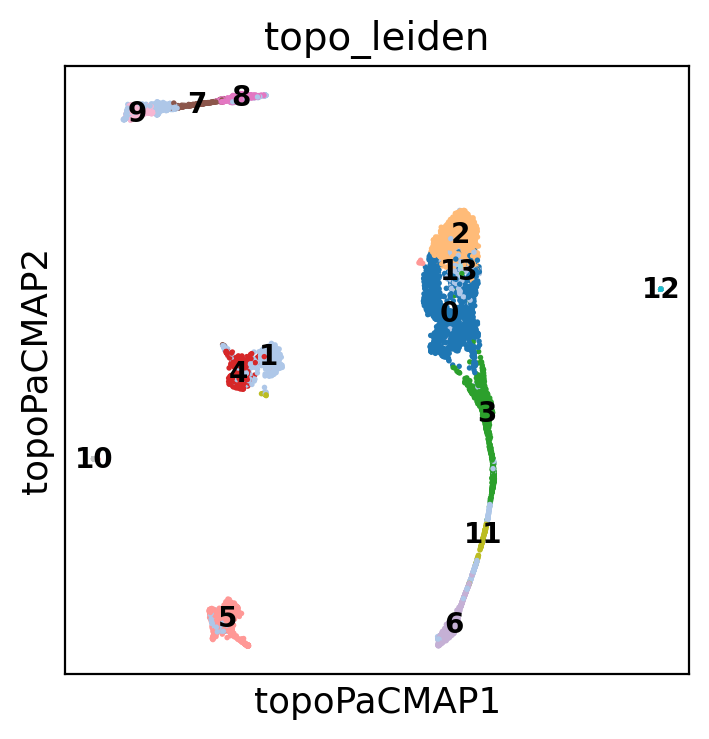

In [24]:
plt.rcParams['figure.figsize']=(4,4)
sc.pl.embedding(adata, basis='topoPaCMAP', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

Note how the diffusion maps below lose part of the structure creating a sparse blob of clusters

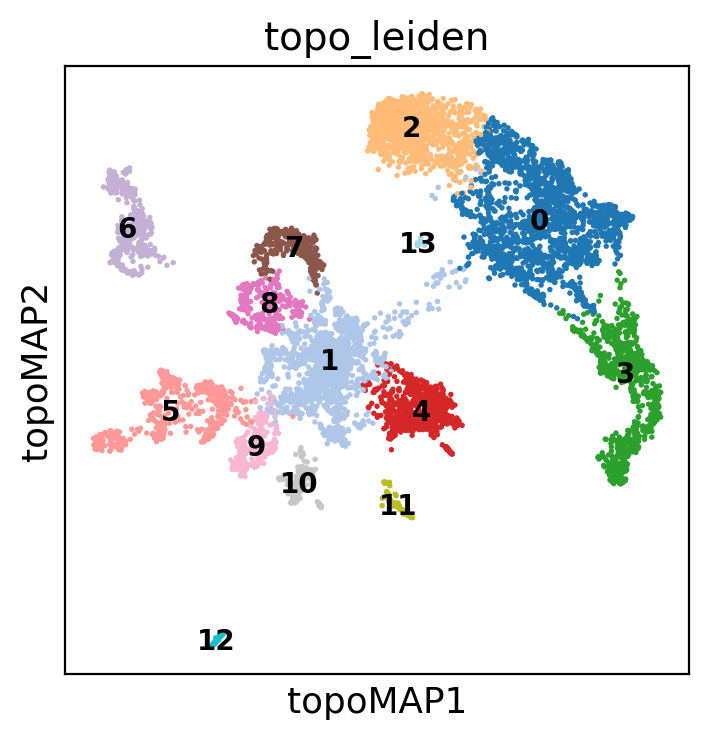

In [25]:
sc.pl.embedding(adata, basis='topoMAP', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

This is instead the UMAP based on PCA, which is maybe the most similar to LBO + PaCMAP

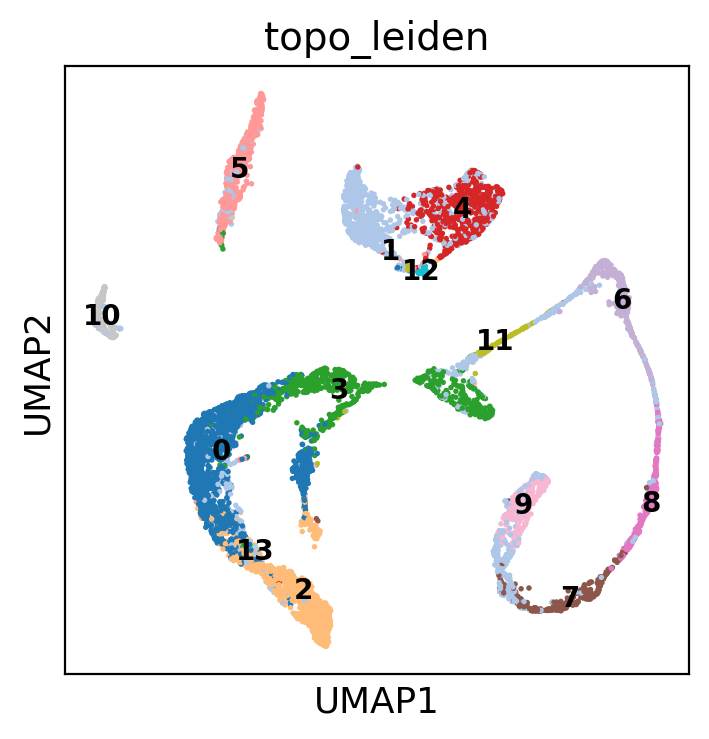

In [26]:
sc.pl.embedding(adata, basis='umap', color=['topo_leiden'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

Here I create a list of cell types and their markers, which I then assign using markers scores [calculated as in Seurat](https://satijalab.org/seurat/reference/addmodulescore) using one of the scripts we downloaded

In [27]:
markers = dict() #make an empty dictionary
### SPERMATOCYTOGENESIS
markers['SpermatogoniaA'] = ['ID4','HMGA1']
markers['SpermatogoniaB'] = ['MKI67','DMRT1','STRA8']
markers['SpermatocytesI'] = ['MEIOB','PRSS50','SYCP1','TEX101']
markers['SpermatocytesII'] = ['PIWIL1','ACRV1','SPATA16','CLGN']
### SPERMIOGENESIS
markers['Round.Spt'] = ['SPATA9','SPAM1'] #Round spermatids
markers['Elong.Spt'] = ['PRM1','PRM2'] #Elongated spermatids
### SOMATIC CELLS
markers['Sertoli'] = ['CTSL', 'VIM', 'GATA4']
markers['Macroph'] = ['CD163','TYROBP']
markers['Leydig'] = ['CFD']
markers['Endothelial'] = ['CD34']
markers['Myoid'] = ['ACTA2']
markers['Smooth_Muscle'] = ['RGS5']

In [28]:
markers_scores, adata = marker_score(markers, adata)

In [29]:
adata.obs['clusters'] = clustersByScores(adata, markers_scores, leidenClusters=adata.obs['topo_leiden'])

We can look at the clustering. See how the cell types enclosed in a tubule are often close together, while other cell types are in separated clusters

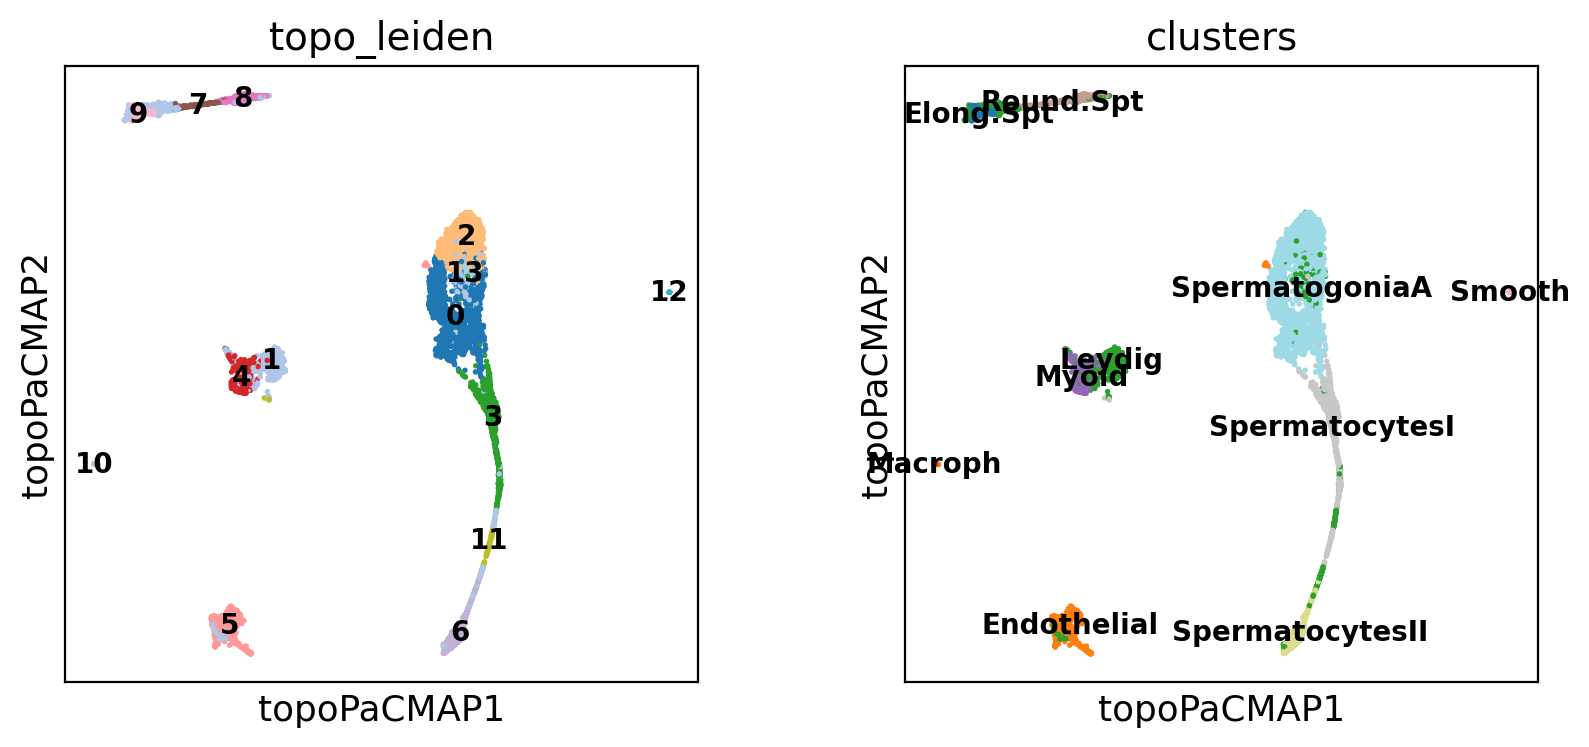

In [30]:
sc.pl.embedding(adata, basis='topoPaCMAP', color=['topo_leiden','clusters'],
                 palette='tab20', ncols=2, legend_loc='on data', legend_fontsize=10)

### Plot single LBO eigenvectors

Now, what about looking at the eigenvectors of the LBO, and see what tey highlight in our data?

Below, notice that the eigenvectors matrix has 250 columns, where each is an eigenvector. Eigenvectors are already normalized.


In [31]:
adata.obsm['X_eigenvectors'].shape

(7765, 250)

Below there is a question that you can solve by exploring some eigenvectors with the input box after the question:

In [46]:
#| echo: false
git_url='https://raw.githubusercontent.com/hds-sandbox/scverse-2024-workshop/main/Questions/quiz03.json'
display_quiz(git_url, 1, shuffle_answers=True)

<IPython.core.display.Javascript object>

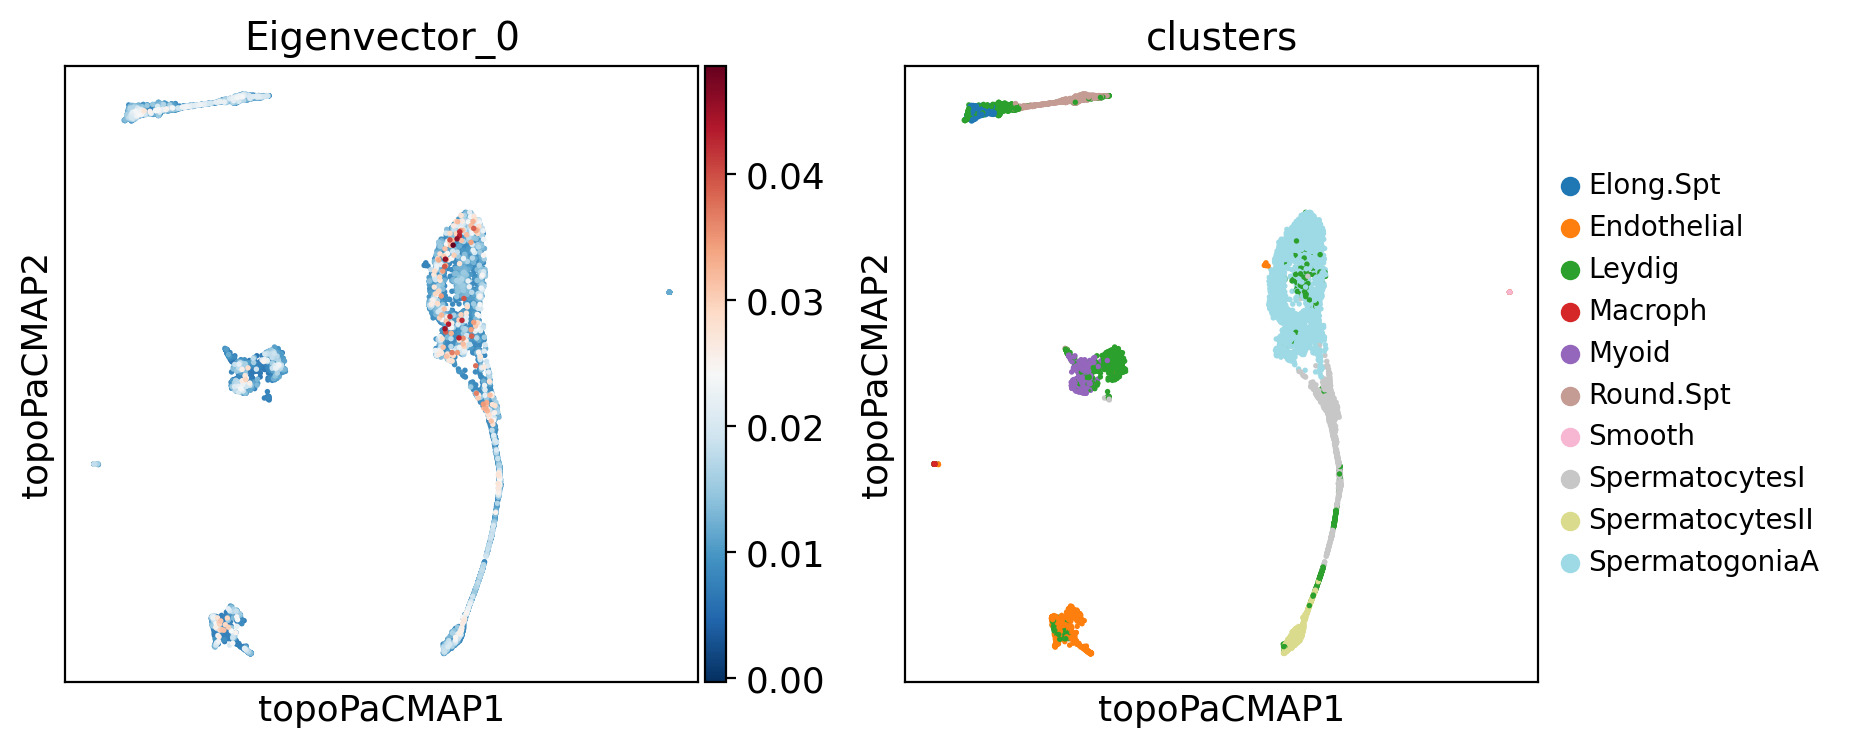

Scores of component 0 by cluster


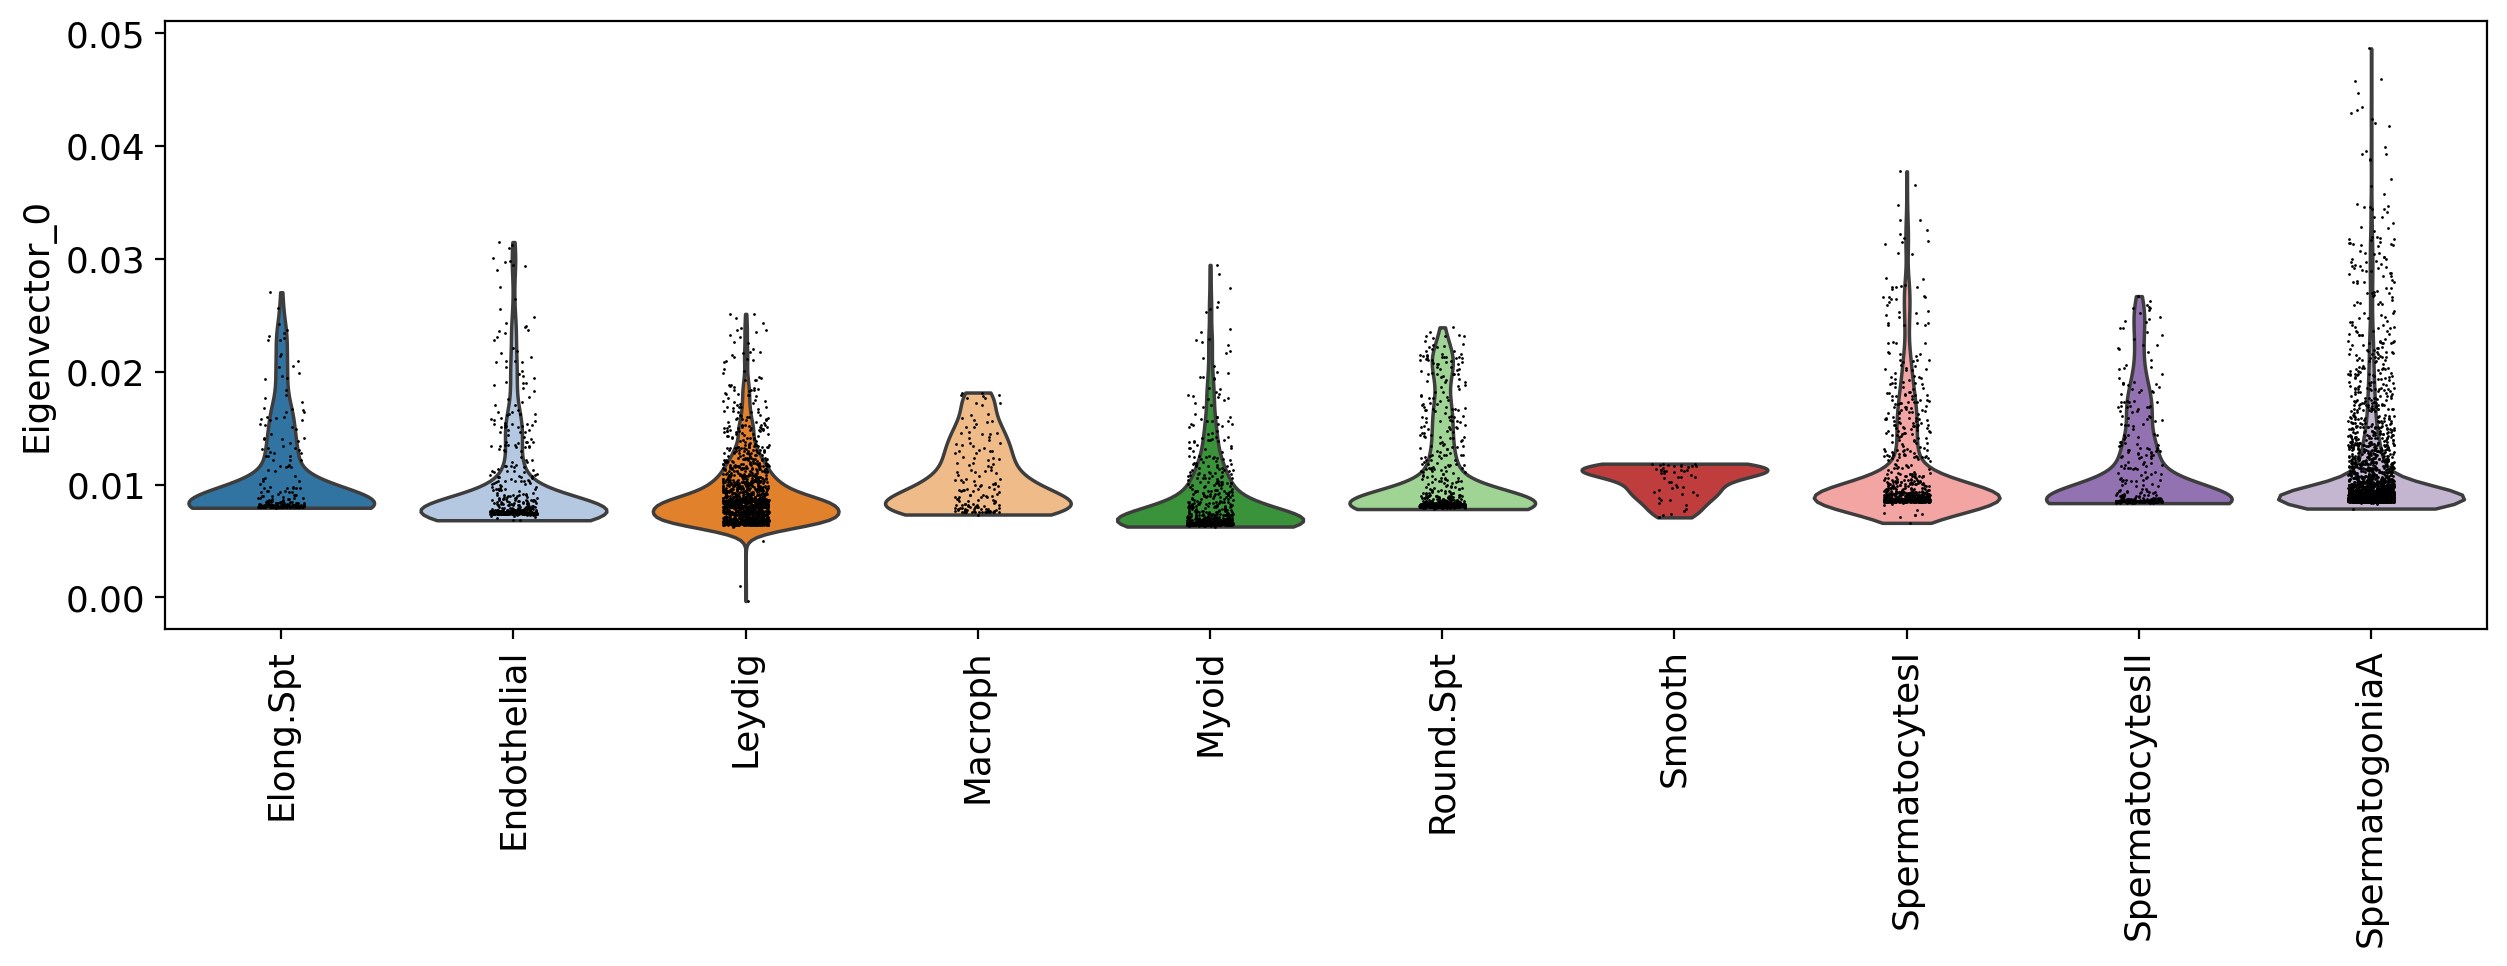

In [44]:
# @title #### DIY: Choose an LBO eigenvector {display-mode: "form"}
component = 0 # @param {type:"number", min:0, max:250, step:1}

adata.obs[f'Eigenvector_{component}'] = adata.obsm['X_eigenvectors'][:,component]

plt.rcParams['figure.figsize']=(4,4)
sc.pl.embedding(adata, basis='topoPaCMAP', color=[f'Eigenvector_{component}','clusters'],
                 palette='tab20', ncols=3, legend_fontsize=10)

plt.rcParams['figure.figsize']=(12,4)
print(f'Scores of component {component} by cluster')
f = sc.pl.violin(adata, keys=[f'Eigenvector_{component}'], groupby='clusters', palette='tab20', rotation=90)

### Some distortion diagnosic

**How to choose a projection based on LBO?** We can look at the **distortion** of each projection. As when drawing a map of the globe, projecting single cell data will create distortions. Those can be determined with the riemannian metric.

Topometry uses the metric to **draw ellipses around some of the points to show distortions**. The **directions** in which the ellipses are wider are the directions of distortion, and the **size of the ellipses' axae** represent the distortion intensity.

#### Running the diagnostics

Below we plot distortion ellipses on 500 points for all the projections we based on LBO.

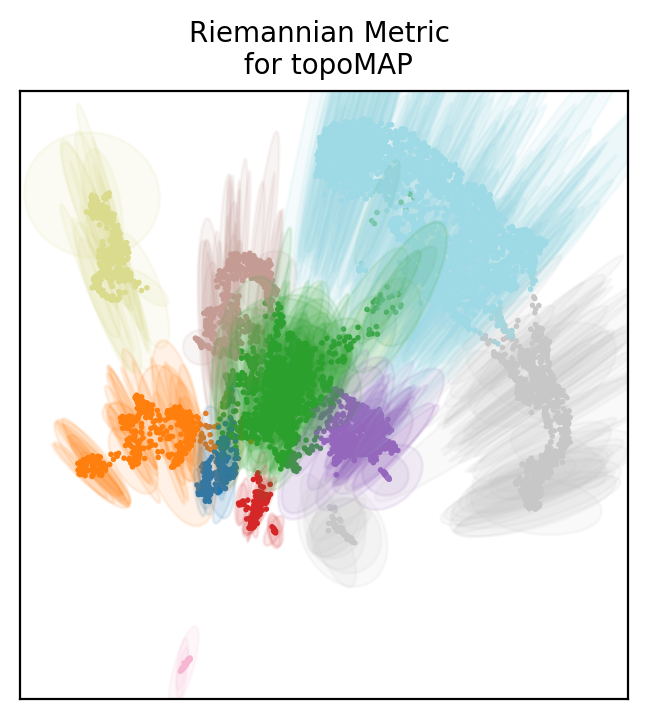

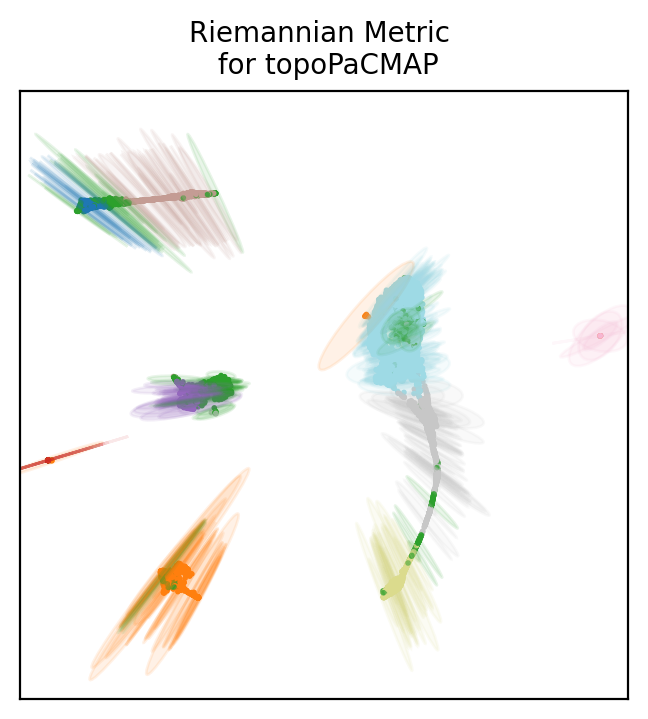

In [32]:
# Get the graph Laplacian of our base graph kernel:
L = tg.base_kernel.L

# Define how many ellipses to plot:
n_plot = 500

# Convert the labels to integers:
labels = adata.obs['clusters'].cat.codes


# Name the projections you want to plot:
projections = ['topoMAP', 'topoPaCMAP']

# Plot the Riemann metric
for name in projections:
    xy_coord = adata.obsm['X_' + name][:,:2]
    tp.pl.plot_riemann_metric(xy_coord, # The coordinates of the projection
                              L,        # The graph Laplacian
                              std=0.5,  # A scaling factor for the ellipses size
                              n_plot=n_plot, # How many ellipses to plot
                              labels=labels,
                              title = f'Riemannian Metric \n for {name}',
                              cmap='tab20', # For coloring
                              random_state=tg.random_state, # For coloring with same colors as before
                              figsize=(4,4) # Size of the figure (NEEDS TO BE SQUARE!!!),
                             )

Look at the first plot with diffusion maps. Ellipses are pretty large and many of them have both axae that are wide, meaning distortions in both directions of the 2D space.

- Usually, cells at the edge of the plot have some **distortion pointing towards the center**. This is phisyological and means that distances are not as large as they appear in the 2D space (similarly to distances which are wrong at the edges of the planar world map).

- If **all cells** including those at the center of the plot have large distortions, then the projection is not reliable, because all points coordinates are distorted.

The diffusion map does not seem a very good projection of the data. PaCMap is definitely more reliable, showing mostly only distortion towards the center from the edges.

# Done!

So this is the end of the workshop. What are the most important points to get out of this?

- **PCA is not too reliable** to base your research on, even though it is accepted as the gold standard in preprocessing. It flattens out non-linearity and creates biases in the other methods which use PCA
- **LBO models geometry** and create harmonics to which you can base any other projection on
- **There is no best** projection method - evaluate distortions of various LBO-based projections and choose accordingly. **Do not assume one method is best** (as what you usually do with PCA + UMAP)

# Not Done! Bonus: Interactive plots

You might want to document your notebook on your own webpage, and why not, show some interactive plots. Here you can do it easily with a library called [`plotly express`](https://plotly.com/python/plotly-express/).

For example you can plot your PaCMAP with clusters and with a specific gene expression when you hover the mouse.

In [70]:
fig = px.scatter(x=adata.obsm['X_topoPaCMAP'][:,0],
                 y=adata.obsm['X_topoPaCMAP'][:,1],
                 color=adata.obs.clusters,
                 hover_name=pd.Series(adata[:,"PRM1"].X[:,0] ),
                 title="Clusters on PacMAP and PRM1 expression on hovering")
fig.show()

You can also use bubble sizes to look at positive numbers, such as the eccentricity of the ellipses we visualized before.Higher eccentricity means higher distortion in axae directions. You can add an animation slider, here for example on different batches.

In [82]:
from topo.utils import get_eccentricity

L = tg.base_kernel.L

eccentricities = get_eccentricity(adata.obsm['X_topoMAP'], L)

adata.obs['topoMAP_eccentricities'] = eccentricities

In [88]:
fig = px.scatter(x=adata.obsm['X_topoMAP'][:,0],
                 y=adata.obsm['X_topoMAP'][:,1],
                 size=adata.obs.topoMAP_eccentricities,
                 size_max=10,
                 color=adata.obs.clusters,
                 animation_frame=adata.obs.batch,
                 title="Diffusion Maps colored by cluster, sized by eccentricities with selector for batches")
fig.show()

The same plot for PaCMAP shows smaller eccentricities as you would expect.

In [84]:
from topo.utils import get_eccentricity

L = tg.base_kernel.L

eccentricities = get_eccentricity(adata.obsm['X_topoPaCMAP'], L)

adata.obs['topoPaCMAP_eccentricities'] = eccentricities

In [87]:
fig = px.scatter(x=adata.obsm['X_topoPaCMAP'][:,0],
                 y=adata.obsm['X_topoPaCMAP'][:,1],
                 size=adata.obs.topoPaCMAP_eccentricities,
                 size_max=10,
                 color=adata.obs.clusters,
                 animation_frame=adata.obs.batch,
                 title="PaCMAP colored by cluster, sized by eccentricities\nwith selector for batches")
fig.show()

# Done for good!

Ok now you are really done. You can see all the plots above in the web version of this tutorial!

# References

::: {#refs}
:::